In [1]:
from unstructured_resample import LegacyVTKReader
import numpy as np
import sys, os
import matplotlib.pyplot as plt
from skimage import measure
from scipy import ndimage



Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [23]:
ifn = r"E:\sim_1377\npz_files\Wing_v2_pipe_dirty_with_dye_lvl=12_CFL=10.000000_TV=1.000000_angle=-0.800000_Re=1377.000000_0327.npz"
# Split the filename to remove the extension
base_name = os.path.splitext(ifn)[0]

# Split by underscores and get the last part
timestep_str = base_name.split('_')[-1]
int(timestep_str)

327

In [24]:
base_name

'E:\\sim_1377\\npz_files\\Wing_v2_pipe_dirty_with_dye_lvl=12_CFL=10.000000_TV=1.000000_angle=-0.800000_Re=1377.000000_0327'

Found NPZ version of data, loading that instead of original...
Resampling velocity, vorticity, and concentration...


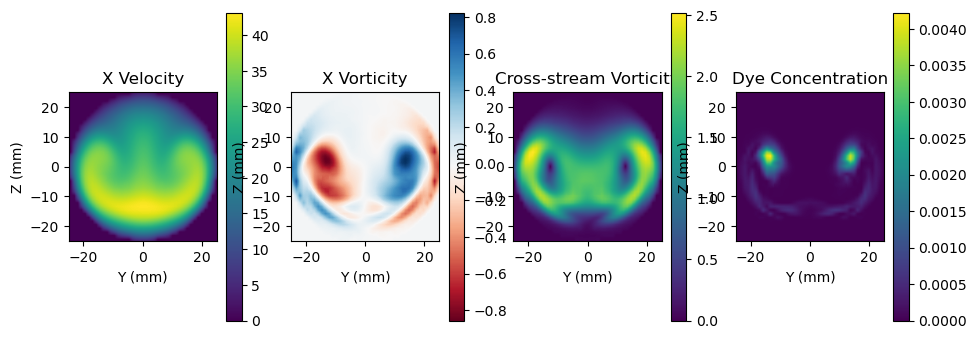

In [25]:

# ifn = r"E:\sim_1545\npz_files\Wing_v2_pipe_dirty_with_dye_lvl=12_CFL=10.000000_TV=1.000000_angle=-0.800000_Re=1545.000000_0175.npz"

bfn = os.path.splitext(ifn)[0]
ifn_npz = bfn + '.npz'
ffn = bfn + '.png'

if os.path.exists(ifn_npz):
    print('Found NPZ version of data, loading that instead of original...')
    src = LegacyVTKReader(ifn_npz)
elif os.path.exists(ifn):
    print('Loading source file... this may take a minute')
    src = LegacyVTKReader(ifn)
    print(f'Saving NPZ version of source to "{ifn_npz}"')
    src.save(ifn_npz)
else:
    raise ValueError('Source file not found!')


x = np.linspace(-25, 25, 150)
X = np.zeros((len(x), len(x), 3))
X[..., 2] = x.reshape(-1, 1)
X[..., 1] = x.reshape(1, -1)
X[..., 0] = 520
imshow_kwargs = dict(origin='lower', extent=[x.min(), x.max(), x.min(), x.max()])

print("Resampling velocity, vorticity, and concentration...")
# Note: resampling multiple fields at once is faster than one at a time
# This is because the cell index can be reused.
V, omega, c = src.resample(X, 'velocity', 'vorticity', 'concentration')

plt.figure(figsize=(11, 4))

plt.subplot(141)
plt.title('X Velocity')
plt.imshow(V[..., 0], **imshow_kwargs)
# for contour in contours:
#     plt.plot(x[contour[:, 1].astype(int)], y[contour[:, 0].astype(int)], linewidth=2)
plt.xlabel('Y (mm)')
plt.ylabel('Z (mm)')
plt.colorbar()

plt.subplot(142)
plt.title('X Vorticity')
plt.imshow(omega[..., 0], cmap='RdBu', **imshow_kwargs)
# for contour in contours:
#     plt.plot(x[contour[:, 1].astype(int)], y[contour[:, 0].astype(int)], linewidth=2)
plt.xlabel('Y (mm)')
plt.ylabel('Z (mm)')
plt.colorbar()

plt.subplot(143)
plt.title('Cross-stream Vorticity')
plt.imshow(np.sqrt(V[..., 1]**2+V[..., 2]**2), cmap='viridis', **imshow_kwargs)
# for contour in contours:
#     plt.plot(x[contour[:, 1].astype(int)], y[contour[:, 0].astype(int)], linewidth=2)
plt.xlabel('Y (mm)')
plt.ylabel('Z (mm)')
plt.colorbar()


plt.subplot(144)
plt.title('Dye Concentration')
plt.imshow(c[..., 0], cmap='viridis', **imshow_kwargs)
# for contour in contours:
#     plt.plot(x[contour[:, 1].astype(int)], y[contour[:, 0].astype(int)], linewidth=2)
plt.xlabel('Y (mm)')
plt.ylabel('Z (mm)')
plt.colorbar()

In [107]:
helicity = np.sum(V * omega, axis=-1)
helicity.shape

(300, 300, 300)

In [12]:
# Define the 3D grid
x = np.linspace(src.points.min(axis=0)[0], src.points.max(axis=0)[1], 300)
y = np.linspace(-25, 25, 300)
z = np.linspace(-25, 25, 300)

# Create a meshgrid for 3D coordinates
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Stack the coordinates to create the 3D grid points
grid_points = np.stack([X, Y, Z], axis=-1)

print("Resampling velocity, vorticity, and concentration...")
# Note: resampling multiple fields at once is faster than one at a time
# This is because the cell index can be reused.
# V, omega, c,g = src.resample(grid_points, 'velocity', 'vorticity', 'concentration', 'geometry')
V, omega, c = src.resample(grid_points, 'velocity', 'vorticity', 'concentration')

# V = np.transpose(V,(0,2,1,3))
# omega = np.transpose(omega,(0,2,1,3))
# c = np.transpose(c,(0,2,1,3))
# g = np.transpose(g,(0,2,1,3))
print(V.shape)

Resampling velocity, vorticity, and concentration...
(300, 300, 300, 3)


In [40]:
print(src.points.min(axis=0)[0])
print(src.points.max(axis=0)[0])

-96.0
534.0


In [177]:
50/y.shape[0]

0.16666666666666666

In [161]:
x[250]

247.6454849498328

In [236]:
omega.shape

(300, 300, 300, 3)

In [240]:
(y.max()-y.min())/omega.shape[2]

0.16666666666666666

In [22]:
import matplotlib.patheffects as pe
from scipy.ndimage import center_of_mass
from skimage.draw import polygon
# for plane in range(300):
plane = 150
# Sample data loading (replace with actual data loading code)
data = omega[plane, :, :, 0]  # x, y, z
array = c[plane,:,:,0]

data = np.rot90(data, k=1)
array = np.rot90(array,k=1)
data = np.flipud(data)
array = np.flipud(array)

contours = measure.find_contours(array, 0.0025)
contours = sorted(contours, key=lambda c: c[:, 1].min())

centers_of_mass = []
for contour in contours:
    # Create a mask for each contour
    mask = np.zeros_like(array, dtype=bool)
    # Get the row and column indices for the contour
    rr, cc = polygon(contour[:, 0], contour[:, 1], mask.shape)
    # Fill the mask inside the contour
    mask[rr, cc] = True
    # Calculate the center of mass of the mask
    com = center_of_mass(mask*array)
    # Append the center of mass to the list
    centers_of_mass.append(com)

interp_y = interp1d(np.arange(len(y)), y)
interp_z = interp1d(np.arange(len(z)), z)

for i, com in enumerate(centers_of_mass):
    print(f"Contour {i + 1}: Center of Mass = {interp_y(com[1])},{interp_z(com[0])}")

# Define the size of the array
rows, cols = data.shape

# Create masks for the left and right halves
half_mask_left = np.zeros_like(data, dtype=bool)
half_mask_left[:, :cols // 2] = True

half_mask_right = np.zeros_like(data, dtype=bool)
half_mask_right[:, cols // 2:] = True

radius = 20/(50/omega.shape[2])  # Adjust the radius as needed
center = (rows // 2, cols // 2)  # Center of the circle
Y, X = np.ogrid[:rows, :cols]
dist_from_center = np.sqrt((X - center[1])**2 + (Y - center[0])**2)
circular_mask = dist_from_center <= radius
# Combine masks to create D-shaped masks
d_shape_mask_left = half_mask_left & circular_mask
d_shape_mask_right = half_mask_right & circular_mask

# Apply the masks to the data
masked_data_left = np.copy(data)
masked_data_right = np.copy(data)
masked_data_left[~d_shape_mask_left] = np.nan  # Set excluded values to NaN for visualization
masked_data_right[~d_shape_mask_right] = np.nan  # Set excluded values to NaN for visualization

# Apply the masks to the data
masked_data_left2 = np.copy(data)
masked_data_right2 = np.copy(data)
masked_data_left2[~half_mask_left] = np.nan  # Set excluded values to NaN for visualization
masked_data_right2[~half_mask_right] = np.nan  # Set excluded values to NaN for visualization

# Define clipping ranges
min_val = 0.15
max_val = 5

# Clip the data for left mask
clipped_array_left = np.clip(masked_data_left2, -max_val, -min_val)
clipped_array_left[masked_data_left2 < -max_val] = 0
clipped_array_left[masked_data_left2 > -min_val] = 0
clipped_array_left = np.nan_to_num(clipped_array_left, nan=0.0)

# Calculate center of mass for left mask
if clipped_array_left.sum() != 0:
    center_of_mass_left = ndimage.center_of_mass(clipped_array_left)
else:
    center_of_mass_left = (np.nan, np.nan)

# Clip the data for right mask
clipped_array_right = np.clip(masked_data_right2, min_val, max_val)
clipped_array_right[masked_data_right2 < min_val] = 0
clipped_array_right[masked_data_right2 > max_val] = 0
clipped_array_right = np.nan_to_num(clipped_array_right, nan=0.0)

# Calculate center of mass for right mask
if clipped_array_right.sum() != 0:
    center_of_mass_right = ndimage.center_of_mass(clipped_array_right)
else:
    center_of_mass_right = (np.nan, np.nan)

# Define the new extent
extent = (-25, 25, -25, 25)

# Rescale the center of mass coordinates
rescaled_com_left = (
    ((center_of_mass_left[1] + 0.5) / cols) * (extent[1] - extent[0]) + extent[0],
    ((center_of_mass_left[0] + 0.5) / rows) * (extent[3] - extent[2]) + extent[2]
)

rescaled_com_right = (
    ((center_of_mass_right[1] + 0.5) / cols) * (extent[1] - extent[0]) + extent[0],
    ((center_of_mass_right[0] + 0.5) / rows) * (extent[3] - extent[2]) + extent[2]
)

# Calculate circulation (sum of the clipped array values)
# left_circ = clipped_array_left.sum()
# right_circ = clipped_array_right.sum()
left_circ = np.nansum(masked_data_left*(50/omega.shape[2])*(50/omega.shape[1]))
right_circ = np.nansum(masked_data_right*(50/omega.shape[2])*(50/omega.shape[1]))
# com_right.append(right_circ)
# com_left.append(left_circ)

plt.figure(figsize=(11, 4))
plt.subplot(131)
plt.title('Left D array')
plt.imshow(masked_data_left, cmap="RdBu", **imshow_kwargs)
plt.clim(-3.5,3.5)
plt.xlabel('Y (mm)')
plt.ylabel('Z (mm)')
plt.colorbar()
plt.scatter(rescaled_com_left[0], rescaled_com_left[1], color='blue', label=f'Left CoM={left_circ:.1f}mm^2/s')
plt.legend()


plt.subplot(132)
plt.title('X Vorticity')
plt.imshow(data, cmap='RdBu', **imshow_kwargs)
plt.colorbar()
plt.clim(-3.5,3.5)
plt.contour(d_shape_mask_left, colors='green', linewidths=1,extent=extent)
plt.contour(d_shape_mask_right, colors='yellow', linewidths=1,extent=extent)
plt.scatter(rescaled_com_right[0], rescaled_com_right[1], color='red', label=f'Right CoM={right_circ:.1f}mm^2/s')
plt.scatter(rescaled_com_left[0], rescaled_com_left[1], color='blue', label=f'Left CoM={left_circ:.1f}mm^2/s')
plt.text(-27,-26, f"{(x[plane]):.1f} mm from wing", color='white',fontsize=14,path_effects=[pe.withStroke(linewidth=4, foreground="black")])
plt.xlabel('Y (mm)')
plt.ylabel('Z (mm)')


plt.subplot(133)
plt.title('Right Clipped array')
plt.imshow(clipped_array_right, cmap='RdBu', **imshow_kwargs)
plt.clim(-3.5,3.5)
plt.xlabel('Y (mm)')
plt.ylabel('Z (mm)')
plt.colorbar()
plt.scatter(rescaled_com_right[0], rescaled_com_right[1], color='red', label=f'Right CoM={right_circ:.1f}mm^2/s')
plt.legend()
# plt.savefig(f'circulations_1545_{plane:04d}.png')
# plt.close()



ValueError: A value (77.9242703762206) in x_new is above the interpolation range's maximum value (4).

In [227]:
import subprocess
# Define paths
output_filename =  "circulations_1545.mp4"
input_pattern = "circulations_1545_%04d.png"
framerate = 34.8  # Specify the framerate

# Define ffmpeg command
ffmpeg_cmd = [
    "ffmpeg", 
    "-framerate", str(framerate), 
    "-i", input_pattern, 
    "-c:v", "libx264", 
    "-r", "30", 
    "-pix_fmt", "yuv420p", 
    output_filename
]

# Run the command and capture the output
result = subprocess.run(ffmpeg_cmd, capture_output=True, text=True)

# Print the output and error (if any)
print("Standard Output:\n", result.stdout)
print("Standard Error:\n", result.stderr)

# Check if there was an error
if result.returncode != 0:
    print(f"ffmpeg command failed with return code {result.returncode}")
else:
    print("ffmpeg command executed successfully.")
    
    # Remove the .png files if the video was successfully created
    for i in range(80,172):
        os.remove(f"circulations_1545_{(i-80):04d}.png")


Standard Output:
 
Standard Error:
 ffmpeg version 4.4-essentials_build-www.gyan.dev Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.2.0 (Rev6, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-lzma --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-sdl2 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-libass --enable-libfreetype --enable-libfribidi --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-ffnvcodec --enable-nvdec --enable-nvenc --enable-d3d11va --enable-dxva2 --enable-libmfx --enable-libgme --enable-libopenmpt --enable-libopencore-amrwb --enable-libmp3lame --enable-libtheora --enable-libvo-amrwbenc --enable-libgsm -

In [21]:
import numpy as np
from scipy.interpolate import interp1d

# Example arrays representing spatial coordinates
y = np.array([10.0, 20.0, 30.0, 40.0, 50.0])  # Example y values
z = np.array([1.1, 2.2, 3.3, 4.4, 5.5])      # Example z values

# Example center of mass coordinates (non-integer)
com = (2.3, 1.8)  # Example center of mass coordinates (row, column)

# Linear interpolation function for y and z
interp_y = interp1d(np.arange(len(y)), y)
interp_z = interp1d(np.arange(len(z)), z)

# Interpolated spatial coordinates
y_value = interp_y(com[1])
z_value = interp_z(com[0])

print(f"Interpolated y value: {y_value}")
print(f"Interpolated z value: {z_value}")


Interpolated y value: 28.0
Interpolated z value: 3.63


In [57]:
print(com[1])
print(com[0])

1.8
2.3


In [51]:
print(y[int(com[1])])
print(z[int(com[0])])

14.195979899497488
-4.145728643216081


In [76]:
contours[1]

array([[ 46.05151258, 161.        ],
       [ 46.36270434, 160.        ],
       [ 46.63547212, 159.        ],
       [ 46.80893796, 158.        ],
       [ 46.78656132, 157.        ],
       [ 46.76409534, 156.        ],
       [ 46.74153948, 155.        ],
       [ 46.71889322, 154.        ],
       [ 46.60236864, 153.        ],
       [ 46.29357226, 152.        ],
       [ 46.        , 151.18568141],
       [ 45.92677253, 151.        ],
       [ 45.48393273, 150.        ],
       [ 45.        , 149.10200389],
       [ 44.89469697, 149.        ],
       [ 44.        , 148.25564887],
       [ 43.07849097, 148.        ],
       [ 43.        , 147.97146643],
       [ 42.        , 147.62582753],
       [ 41.        , 147.31035211],
       [ 40.        , 147.02125678],
       [ 39.        , 147.96959465],
       [ 38.97743065, 148.        ],
       [ 38.393846  , 149.        ],
       [ 38.        , 149.89198077],
       [ 37.9547418 , 150.        ],
       [ 37.5560564 , 151.        ],
 

In [71]:
for com in centers_of_mass:
    print(com)

(83.22357723577235, 40.300813008130085)
(83.78187919463087, 156.25838926174498)


In [71]:
3*np.nan

nan

In [40]:
import numpy as np
import matplotlib.pyplot as plt
com_left = []
com_right = []
for i in range(omega.shape[0]):
    # Sample data loading (replace with actual data loading code)
    data = omega[i, :, :, 0]  # Assume omega is already defined
    contours = measure.find_contours(c[i,:,:,0], 0.0025)

    # Define the size of the array
    rows, cols = data.shape

    # Create masks for the left and right halves
    half_mask_left = np.zeros_like(data, dtype=bool)
    half_mask_left[:, :cols // 2] = True

    half_mask_right = np.zeros_like(data, dtype=bool)
    half_mask_right[:, cols // 2:] = True

    # Apply the masks to the data
    masked_data_left = np.copy(data)
    masked_data_right = np.copy(data)
    masked_data_left[~half_mask_left] = np.nan  # Set excluded values to NaN for visualization
    masked_data_right[~half_mask_right] = np.nan  # Set excluded values to NaN for visualization

    # Define clipping ranges
    min_val = 0.1
    max_val = 5

    # Clip the data for left mask
    clipped_array_left = np.clip(masked_data_left, -max_val, -min_val)
    clipped_array_left[masked_data_left < -max_val] = 0
    clipped_array_left[masked_data_left > -min_val] = 0
    clipped_array_left = np.nan_to_num(clipped_array_left, nan=0.0)

    # Calculate center of mass for left mask
    if clipped_array_left.sum() != 0:
        center_of_mass_left = ndimage.center_of_mass(clipped_array_left)
    else:
        center_of_mass_left = (np.nan, np.nan)

    # Clip the data for right mask
    clipped_array_right = np.clip(masked_data_right, min_val, max_val)
    clipped_array_right[masked_data_right < min_val] = 0
    clipped_array_right[masked_data_right > max_val] = 0
    clipped_array_right = np.nan_to_num(clipped_array_right, nan=0.0)

    # Calculate center of mass for right mask
    if clipped_array_right.sum() != 0:
        center_of_mass_right = ndimage.center_of_mass(clipped_array_right)
    else:
        center_of_mass_right = (np.nan, np.nan)

    # Define the new extent
    extent = (-25, 25, -25, 25)

    # Rescale the center of mass coordinates
    rescaled_com_left = (
        ((center_of_mass_left[1] + 0.5) / cols) * (extent[1] - extent[0]) + extent[0],
        ((center_of_mass_left[0] + 0.5) / rows) * (extent[3] - extent[2]) + extent[2]
    )

    rescaled_com_right = (
        ((center_of_mass_right[1] + 0.5) / cols) * (extent[1] - extent[0]) + extent[0],
        ((center_of_mass_right[0] + 0.5) / rows) * (extent[3] - extent[2]) + extent[2]
    )

    # Calculate circulation (sum of the clipped array values)
    # left_circ = clipped_array_left.sum()
    # right_circ = clipped_array_right.sum()
    left_circ = np.sum(clipped_array_left*(50/omega.shape[2])*(50/omega.shape[1]))
    right_circ = np.sum(clipped_array_right*(50/omega.shape[2])*(50/omega.shape[1]))
    com_right.append(right_circ)
    com_left.append(left_circ)

#     # Plotting the results
#     plt.figure(figsize=(10, 6))
#     plt.imshow(data, cmap='RdBu', **imshow_kwargs)
#     for contour in contours:
#         plt.plot(y[contour[:, 1].astype(int)], z[contour[:, 0].astype(int)], linewidth=2)
#     plt.clim(-2, 2)
#     plt.colorbar()
#     plt.scatter(rescaled_com_left[0], rescaled_com_left[1], color='blue', label=f'Left CoM={left_circ:.1f}mm^2/s')
#     plt.scatter(rescaled_com_right[0], rescaled_com_right[1], color='red', label=f'Right CoM={right_circ:.1f}mm^2/s')
#     plt.legend()
#     plt.xlabel('Y (mm)')
#     plt.ylabel('Z (mm)')
#     plt.title('Vorticity and Center of Mass')
#     plt.savefig(f"com_locate_{i:04d}")
#     plt.close()


# # Define paths
# output_filename =  "com_locate_vid6.mp4"
# input_pattern = "com_locate_%04d.png"
# framerate = 34.8  # Specify the framerate

# # Define ffmpeg command
# ffmpeg_cmd = [
#     "ffmpeg", 
#     "-framerate", str(framerate), 
#     "-i", input_pattern, 
#     "-c:v", "libx264", 
#     "-r", "30", 
#     "-pix_fmt", "yuv420p", 
#     output_filename
# ]

# # Run the command and capture the output
# result = subprocess.run(ffmpeg_cmd, capture_output=True, text=True)

# # Print the output and error (if any)
# print("Standard Output:\n", result.stdout)
# print("Standard Error:\n", result.stderr)

# # Check if there was an error
# if result.returncode != 0:
#     print(f"ffmpeg command failed with return code {result.returncode}")
# else:
#     print("ffmpeg command executed successfully.")
    
#     # Remove the .png files if the video was successfully created
#     for i in range(g.shape[1]):
#         os.remove(f"com_locate_{i:04d}.png")


In [310]:
import subprocess
import os

# Define paths
output_filename =  "com_locate_vid5.mp4"
input_pattern = "com_locate_%04d.png"
framerate = 34.8  # Specify the framerate

# Define ffmpeg command
ffmpeg_cmd = [
    "ffmpeg", 
    "-framerate", str(framerate), 
    "-i", input_pattern, 
    "-c:v", "libx264", 
    "-r", "30", 
    "-pix_fmt", "yuv420p", 
    output_filename
]

# Run the command and capture the output
result = subprocess.run(ffmpeg_cmd, capture_output=True, text=True)

# Print the output and error (if any)
print("Standard Output:\n", result.stdout)
print("Standard Error:\n", result.stderr)

# Check if there was an error
if result.returncode != 0:
    print(f"ffmpeg command failed with return code {result.returncode}")
else:
    print("ffmpeg command executed successfully.")

Standard Output:
 
Standard Error:
 ffmpeg version 4.4-essentials_build-www.gyan.dev Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.2.0 (Rev6, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-lzma --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-sdl2 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-libass --enable-libfreetype --enable-libfribidi --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-ffnvcodec --enable-nvdec --enable-nvenc --enable-d3d11va --enable-dxva2 --enable-libmfx --enable-libgme --enable-libopenmpt --enable-libopencore-amrwb --enable-libmp3lame --enable-libtheora --enable-libvo-amrwbenc --enable-libgsm -

In [11]:
c.shape

(150, 150, 1)

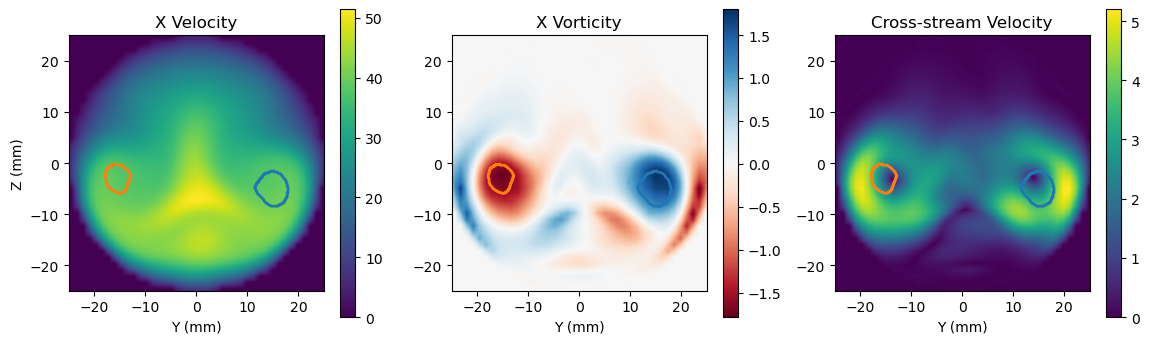

In [19]:
p = 299


contours = measure.find_contours(np.flipud(np.rot90(c[p,:,:,0],k=1)), 0.0020)
# print(f"Number of contours found: {len(contours)}")
plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.title('X Velocity')
plt.imshow(np.flipud(np.rot90(V[p,:,:, 0],k=1)), **imshow_kwargs)
for contour in contours:
    plt.plot(y[contour[:, 1].astype(int)], z[contour[:, 0].astype(int)], linewidth=2)
# plt.text(-27,-26, f"{(x[p]):.1f} mm from wing", color='white',fontsize=14,path_effects=[pe.withStroke(linewidth=4, foreground="black")])

plt.xlabel('Y (mm)')
plt.ylabel('Z (mm)')
plt.colorbar()

plt.subplot(132)
plt.title('X Vorticity')
plt.imshow(np.flipud(np.rot90(omega[p,:,:, 0],k=1)), cmap='RdBu', **imshow_kwargs)
for contour in contours:
    plt.plot(y[contour[:, 1].astype(int)], z[contour[:, 0].astype(int)], linewidth=2)
plt.xlabel('Y (mm)')
plt.colorbar()

plt.subplot(133)
plt.title('Cross-stream Velocity')
plt.imshow(np.flipud(np.rot90(np.sqrt(V[p,:,:, 1]**2+V[p,:,:, 2]**2),k=1)), cmap='viridis', **imshow_kwargs)
for contour in contours:
    plt.plot(y[contour[:, 1].astype(int)], z[contour[:, 0].astype(int)], linewidth=2)
plt.xlabel('Y (mm)')
plt.colorbar()


# plt.subplot(144)
# plt.title('Dye Concentration')
# plt.imshow(c[p,:,:,0],**imshow_kwargs)
# for contour in contours:
#     plt.plot(y[contour[:, 1].astype(int)], z[contour[:, 0].astype(int)], linewidth=2)
# plt.xlabel('Y (mm)')
# plt.colorbar()

# plt.savefig(f"sim_comparison_{i:04d}")
# plt.close()

In [77]:
x[299]

315.0

In [101]:
g.shape

(200, 200, 200, 1)

In [110]:
# imshow_kwargs2 = dict(origin='lower', extent=[x.min(), x.max(), x.min(), x.max()])
for i in range(g.shape[1]):
    plt.figure()
    plt.title('Geometry')
    plt.imshow(g[:,i,:,:])
    plt.xlabel('Y (mm)')
    plt.colorbar()
    plt.savefig(f"geometry_{i:04d}.png")
    plt.close()

# Define paths
output_filename =  "geometry2.mp4"
input_pattern = "geometry_%04d.png"
framerate = 34.8  # Specify the framerate

# Define ffmpeg command
ffmpeg_cmd = [
    "ffmpeg", 
    "-framerate", str(framerate), 
    "-i", input_pattern, 
    "-c:v", "libx264", 
    "-r", "30", 
    "-pix_fmt", "yuv420p", 
    output_filename
]

# Run the command and capture the output
result = subprocess.run(ffmpeg_cmd, capture_output=True, text=True)

# Print the output and error (if any)
print("Standard Output:\n", result.stdout)
print("Standard Error:\n", result.stderr)

# Check if there was an error
if result.returncode != 0:
    print(f"ffmpeg command failed with return code {result.returncode}")
else:
    print("ffmpeg command executed successfully.")
    
    # Remove the .png files if the video was successfully created
    for i in range(g.shape[1]):
        os.remove(f"geometry_{i:04d}.png")


Standard Output:
 
Standard Error:
 ffmpeg version 4.4-essentials_build-www.gyan.dev Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.2.0 (Rev6, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-lzma --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-sdl2 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-libass --enable-libfreetype --enable-libfribidi --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-ffnvcodec --enable-nvdec --enable-nvenc --enable-d3d11va --enable-dxva2 --enable-libmfx --enable-libgme --enable-libopenmpt --enable-libopencore-amrwb --enable-libmp3lame --enable-libtheora --enable-libvo-amrwbenc --enable-libgsm -

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imageio.v3 as iio
import io

# Assuming x and g are already defined as per your context
# x = np.array(...) 
# g = np.array(...)

# Create an in-memory list to hold image data
images = []

# Generate images and store them in memory
imshow_kwargs2 = dict(origin='lower', extent=[x.min(), x.max(), x.min(), x.max()])
for i in range(g.shape[1]):
    plt.figure()
    plt.title('Geometry')
    plt.imshow(g[:, i, :, :], **imshow_kwargs2)
    plt.xlabel('Y (mm)')
    plt.colorbar()
    
    # Save the figure to a BytesIO object
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    
    # Seek to the beginning of the BytesIO object
    buf.seek(0)
    
    # Read the image from the BytesIO object
    img = Image.open(buf)
    
    # Convert to numpy array and append to the images list
    images.append(np.array(img))

# Define the output filename and framerate
output_filename = "geometry3.mp4"
framerate = 34.8  # Specify the framerate

# Use imageio to create a video from the in-memory images
iio.imwrite(output_filename, images, fps=framerate, codec='libx264', pixelformat='yuv420p')

print("Video creation completed successfully.")


Video creation completed successfully.


In [71]:
import matplotlib.pyplot as plt
from skimage import measure
import numpy as np
import subprocess
import os

# Your existing plotting and saving code
for i in range(x.shape[0]):
    contours = measure.find_contours(c[i,:,:,0], 0.0020)
    
    plt.figure(figsize=(14, 4))
    plt.subplot(141)
    plt.title('X Velocity')
    plt.imshow(V[i,:,:, 0], **imshow_kwargs)
    for contour in contours:
        plt.plot(y[contour[:, 1].astype(int)], z[contour[:, 0].astype(int)], linewidth=2)
    plt.xlabel('Y (mm)')
    plt.ylabel('Z (mm)')
    plt.colorbar()

    plt.subplot(142)
    plt.title('X Vorticity')
    plt.imshow(omega[i,:,:, 0], cmap='RdBu', **imshow_kwargs)
    for contour in contours:
        plt.plot(y[contour[:, 1].astype(int)], z[contour[:, 0].astype(int)], linewidth=2)
    plt.xlabel('Y (mm)')
    plt.colorbar()

    plt.subplot(143)
    plt.title('Cross-stream Velocity')
    plt.imshow(np.sqrt(V[i,:,:, 1]**2+V[i,:,:, 2]**2), cmap='viridis', **imshow_kwargs)
    for contour in contours:
        plt.plot(y[contour[:, 1].astype(int)], z[contour[:, 0].astype(int)], linewidth=2)
    plt.xlabel('Y (mm)')
    plt.colorbar()

    plt.subplot(144)
    plt.title('Dye Concentration')
    plt.imshow(c[i,:,:,0],**imshow_kwargs)
    for contour in contours:
        plt.plot(y[contour[:, 1].astype(int)], z[contour[:, 0].astype(int)], linewidth=2)
    plt.xlabel('Y (mm)')
    plt.colorbar()

    plt.savefig(f"sim_comparison_{i:04d}.png")
    plt.close()

# Define paths
output_filename =  "sim_comparison_vid6.mp4"
input_pattern = "sim_comparison_%04d.png"
framerate = 34.8  # Specify the framerate

# Define ffmpeg command
ffmpeg_cmd = [
    "ffmpeg", 
    "-framerate", str(framerate), 
    "-i", input_pattern, 
    "-c:v", "libx264", 
    "-r", "30", 
    "-pix_fmt", "yuv420p", 
    output_filename
]

# Run the command and capture the output
result = subprocess.run(ffmpeg_cmd, capture_output=True, text=True)

# Print the output and error (if any)
print("Standard Output:\n", result.stdout)
print("Standard Error:\n", result.stderr)

# Check if there was an error
if result.returncode != 0:
    print(f"ffmpeg command failed with return code {result.returncode}")
else:
    print("ffmpeg command executed successfully.")
    
    # Remove the .png files if the video was successfully created
    for i in range(x.shape[0]):
        os.remove(f"sim_comparison_{i:04d}.png")


Standard Output:
 
Standard Error:
 ffmpeg version 4.4-essentials_build-www.gyan.dev Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.2.0 (Rev6, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-lzma --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-sdl2 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-libass --enable-libfreetype --enable-libfribidi --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-ffnvcodec --enable-nvdec --enable-nvenc --enable-d3d11va --enable-dxva2 --enable-libmfx --enable-libgme --enable-libopenmpt --enable-libopencore-amrwb --enable-libmp3lame --enable-libtheora --enable-libvo-amrwbenc --enable-libgsm -

In [ ]:


for i in range(x.shape[0]):

    contours = measure.find_contours(c[i,:,:,0], 0.0020)
    # print(f"Number of contours found: {len(contours)}")

    plt.figure(figsize=(14, 4))
    plt.subplot(141)
    plt.title('X Velocity')
    plt.imshow(V[i,:,:, 0], **imshow_kwargs)
    for contour in contours:
        plt.plot(y[contour[:, 1].astype(int)], z[contour[:, 0].astype(int)], linewidth=2)
    plt.xlabel('Y (mm)')
    plt.ylabel('Z (mm)')
    plt.colorbar()

    plt.subplot(142)
    plt.title('X Vorticity')
    plt.imshow(omega[i,:,:, 0], cmap='RdBu', **imshow_kwargs)
    for contour in contours:
        plt.plot(y[contour[:, 1].astype(int)], z[contour[:, 0].astype(int)], linewidth=2)
    plt.xlabel('Y (mm)')
    plt.colorbar()

    plt.subplot(143)
    plt.title('Cross-stream Velocity')
    plt.imshow(np.sqrt(V[i,:,:, 1]**2+V[i,:,:, 2]**2), cmap='viridis', **imshow_kwargs)
    for contour in contours:
        plt.plot(y[contour[:, 1].astype(int)], z[contour[:, 0].astype(int)], linewidth=2)
    plt.xlabel('Y (mm)')
    plt.colorbar()


    plt.subplot(144)
    plt.title('Dye Concentration')
    plt.imshow(c[i,:,:,0],**imshow_kwargs)
    for contour in contours:
        plt.plot(y[contour[:, 1].astype(int)], z[contour[:, 0].astype(int)], linewidth=2)
    plt.xlabel('Y (mm)')
    plt.colorbar()

    plt.savefig(f"sim_comparison_{i:04d}")
    plt.close()


In [200]:
import subprocess
import os

# Define paths
output_filename =  "sim_comparison_vid2.mp4"
input_pattern = "sim_comparison_%04d.png"
framerate = 34.8  # Specify the framerate

# Define ffmpeg command
ffmpeg_cmd = [
    "ffmpeg", 
    "-framerate", str(framerate), 
    "-i", input_pattern, 
    "-c:v", "libx264", 
    "-r", "30", 
    "-pix_fmt", "yuv420p", 
    output_filename
]

# Run the command and capture the output
result = subprocess.run(ffmpeg_cmd, capture_output=True, text=True)

# Print the output and error (if any)
print("Standard Output:\n", result.stdout)
print("Standard Error:\n", result.stderr)

# Check if there was an error
if result.returncode != 0:
    print(f"ffmpeg command failed with return code {result.returncode}")
else:
    print("ffmpeg command executed successfully.")

Standard Output:
 
Standard Error:
 ffmpeg version 4.4-essentials_build-www.gyan.dev Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.2.0 (Rev6, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-lzma --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-sdl2 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-libass --enable-libfreetype --enable-libfribidi --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-ffnvcodec --enable-nvdec --enable-nvenc --enable-d3d11va --enable-dxva2 --enable-libmfx --enable-libgme --enable-libopenmpt --enable-libopencore-amrwb --enable-libmp3lame --enable-libtheora --enable-libvo-amrwbenc --enable-libgsm -

In [70]:
# Remove the .png files if the video was successfully created
for i in range(x.shape[0]):
        os.remove(f"com_locate_{i:04d}.png")

In [173]:
omega[520,:,:, 0].shape

(150, 150)

In [174]:
V.shape

(530, 150, 150, 3)

In [175]:
np.transpose(V).shape

(3, 150, 150, 530)

In [ ]:


plt.title('X Velocity')
plt.imshow(V[0,:,:, 0], **imshow_kwargs)
plt.xlabel('Y (mm)')
plt.ylabel('Z (mm)')
plt.colorbar()


In [147]:
print(x.shape)
print(x.reshape(-1, 1).shape)
print(x.reshape(1, -1).shape)
print(V.shape)
print(c.shape)

(150,)
(150, 1)
(1, 150)
(150, 150, 150, 3)
(150, 150, 150, 1)


In [135]:
cx = x[contour[:, 1].astype(int)].mean()
cy = y[contour[:, 0].astype(int)].mean()

TypeError: Invalid shape (530, 150, 150) for image data

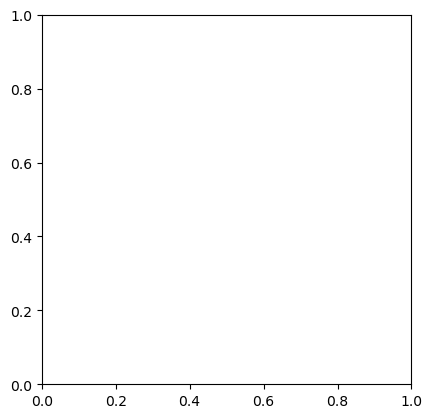

In [181]:
plt.imshow(c[...,0],**imshow_kwargs)
for contour in contours:
    plt.plot(x[contour[:, 1].astype(int)], y[contour[:, 0].astype(int)], linewidth=2)
plt.xlim(-30,30)
plt.ylim(-30,30)
plt.xlabel('Y (mm)')
plt.ylabel('Z (mm)')
plt.colorbar()

In [290]:
from skimage import measure

# c = src.resample(X, 'concentration')
# contours = measure.find_contours(c[...,0], 0.0020)
# print(len(contours))

# Define the scale
x = np.linspace(-25, 25, c.shape[1])
y = np.linspace(-25, 25, c.shape[0])



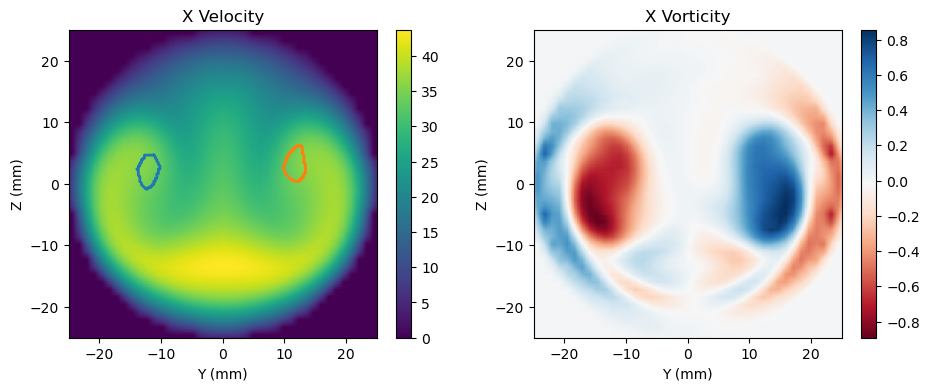

In [111]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.title('X Velocity')
plt.imshow(V[..., 0], **imshow_kwargs)
# plt.imshow(c[...,0],**imshow_kwargs, cmap="viridis")
for contour in contours:
    plt.plot(x[contour[:, 1].astype(int)], y[contour[:, 0].astype(int)], linewidth=2)
plt.xlabel('Y (mm)')
plt.ylabel('Z (mm)')
plt.colorbar()

plt.subplot(122)
plt.title('X Vorticity')
plt.imshow(omega[..., 0], cmap='RdBu', **imshow_kwargs)
plt.xlabel('Y (mm)')
plt.ylabel('Z (mm)')
plt.colorbar()
